In [23]:
import json
import pandas as pd
import numpy as np
import re
import statistics
import urlextract
import fastai
print('fast.ai version is:', fastai.__version__)

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from fastai import *
from fastai.text import *
from collections import Counter

fast.ai version is: 1.0.61


In [2]:
labels = [
    "compete",
    "concert",
    "concert_programm",
    "exhibition",
    "festival",
    "food",
    "free",
    "game",
    "lecture",
    "market",
    "online",
    "open air",
    "party",
    "show",
    "sport",
    "standup",
    "theatre",
    "tour",
    "training",
    "view" #424
]

label_ids = list(range(405, 425))

In [3]:
raw_data = []
with open("file_2.json", "r", encoding="utf-8") as f:
    for line in f:
        e = json.loads(line.strip())
        raw_data.append((e['text'], [label_ids.index(a['label']) for a in e['annotations']]))

In [4]:
class TextPreprocessor:
    def __init__(self):
        self.url_extractor = urlextract.URLExtract()
        self.tag_regex = re.compile(r"<[^>]*>")
        self.email_regex = re.compile(r"[^\s]+@[^\s]+")
        self.number_regex = re.compile(r'\d+(?:\.\d*(?:[eE]\d+))?')
        self.spaces_regex = re.compile(r"\s+")
        self.special_chars = [
            "<", "[", "]", "`", "^", ">", "+", "?", "!", "'", ".", ",", ":",
            "*", "%", "#", "_", "=", "-", "&", '/', '\\', '(', ')', ";", "\"", "«", "»", "|", "•", "—", "–", "●", "►", "\n",
            "@", "$"
        ]
        
    def preprocess_text(self, text):
        text = text.lower()
        text = text.replace('\\xa', ' ')
        text = self.remove_html_tags(text)
        text = self.replace_urls(text)
        text = self.remove_emails(text)
        #text = self.replace_numbers(text)
        text = self.remove_special_characters(text)
        text = text.lower().replace("ё", "е")
        text = re.sub(' +', ' ', text)
        text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
        return text.strip()

    def split_by_tokens(self, sentences):
        for sentence in sentences:
            yield [morph.parse(t.lower().strip())[0].normal_form for t in word_tokenize(sentence)]
    
    def remove_html_tags(self, text):
        text = self.tag_regex.sub(" ", text).split(" ")
        text = filter(len, text)
        text = ' '.join(text)
        return text

    def replace_urls(self, text):
        urls = list(set(self.url_extractor.find_urls(text)))
        urls.sort(key=lambda u: len(u), reverse=True)
        for url in urls:
            text = text.replace(url, "")
        return text

    def remove_emails(self, text):
        return self.email_regex.sub("", text)
    
    def replace_numbers(self, text):
        return self.number_regex.sub(" number ", text)

    def remove_special_characters(self, text):
        for char in self.special_chars:
            text = text.replace(str(char), "")
        return text


In [5]:
preprocessor = TextPreprocessor()
data = [(preprocessor.preprocess_text(d[0]), d[1]) for d in raw_data]

In [6]:
data[123]

('один из главных стендапкомиков страны готов снова войти в образ гламурного подонка и порадовать поклонников бескомпромиссного юмора новыми монологами на самые животрепещущие темыдекабрь для павла воли не обычный месяц а месяц душевных встреч с ценителями своего таланта да и просто с теми кто хочет от души повеселиться и убедиться в том что современный юмор живздоров и вовсю процветает не станет исключением и этот декабрь любимый миллионами комик отправляется в тур по стране в рамках которого выступит и в екатеринбурге на сцене киноконцертного театра космос юмор воли живой яркий острый на большом standup в столице урала артист представит новую программу в которую вошли монологи на злобу дня жизненные зарисовки и уморительные рассуждения о неочевидном смысле происходящего вокруг разумеется не обойдется и без талантливых импровизаций концерт воли это отличный способ поднять себе настроение и зарядиться жизненной энергией',
 [15])

In [15]:
df_train=pd.DataFrame(columns=['Text', 'Label'])
df_test=pd.DataFrame(columns=['Text', 'Label'])

random.shuffle(data)
data_texts = [d[0] for d in data]
data_labels = [" ".join([str(l) for l in d[1]]) for d in data]

In [19]:
df_train['Text'], df_test['Text'], df_train['Label'], df_test['Label'] = train_test_split(data_texts, data_labels, test_size=0.1, random_state=1)

In [21]:
df_val = pd.DataFrame(columns=['Text', 'Label'])

df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=1)

In [26]:
for t, c in Counter([l for sublist in [d[1] for d in data] for l in sublist]).items():
    print("%s = %d" % (labels[t], c))

training = 523
compete = 148
game = 513
tour = 510
theatre = 563
standup = 451
concert = 558
concert_programm = 505
party = 521
free = 1388
sport = 507
open air = 200
show = 513
festival = 561
market = 508
exhibition = 523
lecture = 512
food = 120
view = 506
online = 36


In [28]:
tokenizer = Tokenizer(lang='xx')
data_lm = TextLMDataBunch.from_df(
    '', 
    tokenizer=tokenizer, 
    bs=16, 
    train_df=df_train, 
    valid_df=df_val, 
    text_cols=0,
    label_delim=' ')

In [30]:
data_lm.show_batch()

idx,text
0,сцену зеленого театра вднх свежая порция искрометных шуток на злобу дня будет ожидать зрителей каждую xxunk набирающий обороты телепроект stand up этим летом трансформируется в целую серию xxunk под открытым небом вплоть до 4 сентября избавляться от накопившегося за рабочую неделю стресса будут помогать звездные резиденты шоу в лице виктора комарова александра шаляпина зои xxunk ирины xxunk и многих xxunk июня хедлайнеры вечера слава комиссаренко иван усович и алексей щербаков
1,итоге актеры не только играют вживую но и делают это лежа сидя и даже на xxunk идет 1 час 3 минут xxbos драматическая комедия ситуаций на что может пойти в конкурсе красоты xxunk xxunk женщина если на кону большая квартира и огромный по xxunk меркам приз в двадцать пять тысяч xxunk конкурсанток отчаянно сражаются за главный приз соперничество превращается в xxunk но законы шоубизнеса xxunk xxunk xxunk режиссер несмотря на
2,иллюзии и разберете основные виды психических xxunk углубиться в изучение психологии смогут перейти на следующую ступень курса чтобы узнать подробности нажмите на кнопку xxbos цирковая программа которая соберет вместе более 12 экзотических животных и знаменитых цирковых xxunk xxunk xxunk на настоящих мотоциклах xxunk верблюды xxunk всеми цветами радуги павлины xxunk лошади xxunk препятствия гималайские медведи в горящих xxunk красноярцев ждет xxunk xxunk об шумных и ярких испанских традициях от представления
3,человеком очень серьезным он закончил военный университет и xxunk до капитана но потом круто изменил свою жизнь xxunk себя юмору правда по пути руслан получил еще одно высшее образование уже на xxunk теперь этот обаятельный участник comedy club выходит на сцену даря публике небывалый заряд отличного настроения на его концертах даже самый грустный человек на планете будет хохотать до xxunk ресторане maximilians все будет именно так как мы видим на
4,странствия и безусловно гостей концерта ожидают сюрпризы не будем забывать что концерт праздничный xxbos фестиваль море винила пройдет в пространстве тайга все что связано с пластинками оборудованием и xxunk в одном месте маркет выставка и xxunk сентября пройдет грандиозный праздник для всех любителей виниловых пластинок и xxunk культуры море винила раскинется в пространстве тайга ценителям и просто xxunk скучать не придется программа фестиваля будет весьма xxunk это продажа виниловых пластинок


In [31]:
weights_pretrained = 'ULMFit/lm_5_ep_lr2-3_5_stlr'
itos_pretrained = 'ULMFit/itos'
pretained_data = (weights_pretrained, itos_pretrained)

In [34]:
config = awd_lstm_lm_config.copy()
config['n_hid'] = 1150
learn_lm = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained_fnames=pretained_data, drop_mult=0.3)
learn_lm.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


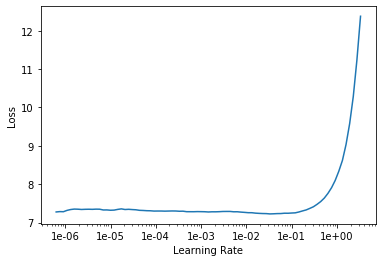

In [35]:
learn_lm.lr_find()
learn_lm.recorder.plot()

In [36]:
learn_lm.fit_one_cycle(3, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.316019,5.666403,0.198975,47:58
1,5.562184,5.349268,0.221925,49:04
2,4.623022,5.264508,0.230666,49:12


In [52]:
learn_lm.predict("Сегодня в Минске", n_words=20)

'Сегодня в Минске проходят лекции и дискуссии можно провести всех со всего мира в этот день организует фестиваль авторских игрушек в клубе петербургскую'

In [55]:
model = load_learner("")

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(MultiCategory tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.]),
 tensor([6.8769e-09, 1.1508e-05, 1.9796e-19, 3.2919e-10, 3.8633e-07, 4.3129e-09,
         4.1542e-10, 7.5069e-07, 3.8707e-10, 1.7216e-10, 5.5091e-05, 7.0980e-05,
         1.7721e-08, 4.1713e-12, 9.4743e-08, 8.4092e-12, 6.3058e-01, 2.1811e-11,
         5.8086e-03, 6.0468e-08]))

In [58]:
torch_labels = sorted([str(i) for i in range(20)])
def predict(text):
    text = preprocessor.preprocess_text(text)
    p = model.predict(text)
    result = []
    for index, i in enumerate(p[1]):
        if int(i) == 1:
            true_label = int(torch_labels[index])
            result.append(labels[true_label])
    return result